# Reconstrution Network

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os

# move into the correct dirrectory, e.g. move up one directory level iif this cell is run for the first time
try:
    a = first_time
except NameError:
    print("Running first time, moving up one dir level")
    os.chdir('..')  # Move up one directory level to the root directory of project
    first_time = False

print("This path should be the root directory of the project: ", os.getcwd())
    


Running first time, moving up one dir level
This path should be the root directory of the project:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


#### Import Libraries

In [3]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import datetime

import time



#### Project Imports

In [5]:
from data.model_classes import Mug, Bottle
from data.dataconverter import DataConverter
from data.reconstruction_dataset import *
from neural_nets.models.unet import UNetSmall, UNet1, count_parameters


### Dataset
Creating the dataset object and applzing transformations to the data.

In [6]:
# Outcommented because there are currently someproblems running it in the notebook

# generate data
dataconverter = DataConverter(
    classes=[Mug(),Bottle()],
    min_order = 5,
    tact_order = 10,
    tact_number=40
    
)
# set regenerate to true, if you run this after changes in dataconverter have been made
dataconverter.generate_2d_dataset(show_results=False, regenerate=False)


class mug already downloaedd. Skipping download.
class bottle already downloaedd. Skipping download.
2D images for classmug already exist. Skipping conversion.
2D images for classbottle already exist. Skipping conversion.
Generating annotation CSV files for training and testing with a split ratio of 0.9:0.1.
Error: Not all tactile samples were generated correctly!


In [7]:
csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


<Figure size 640x480 with 0 Axes>

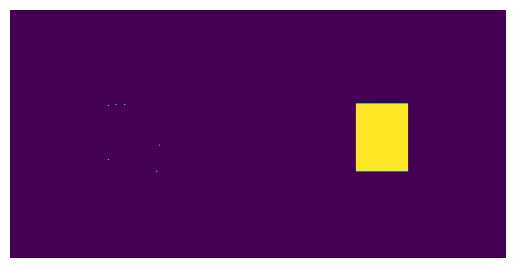

In [8]:
example_data = dataset[5]

plt.figure()
print(example_data['image'])
show_datapair(example_data['image'], example_data['label'])
plt.show()

#### Split Dataset into train, validation and test dataset

In [10]:
# Define the sizes for train, validation, and test
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size 

# Split the dataset
val_dataset, train_dataset = random_split(dataset, [val_size, train_size])


### Hyperparamters

In [11]:
num_epochs = 50
batch_size = 16
learning_rate = 1e-4
ModelClass = UNet1

def weight_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
            init.constant_(layer.bias, 0)

    elif isinstance(layer, nn.Linear):
        init.xavier_normal_(layer.weight)
        if layer.bias is not None:
            init.constant_(layer.bias, 0)

### Dataloader
Creating a dataloader based on the dataset for batch processing.

TODO: Remove spacing in figure.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)



batch = next(iter(train_loader))
print(batch['image'].shape)

if False:
    show_datapair_batch(next(iter(train_loader)))


torch.Size([16, 1, 256, 256])


### Initialize Network

In [13]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelClass().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# initialize parameters
model.apply(weight_init)
fresh_initialized = True


print("Device: ", device)

count_parameters(model)

Device:  cuda
Total trainable parameters: 27987457


### Training

Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

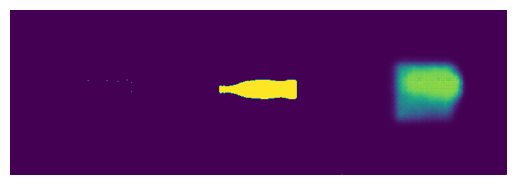

Epoch [1/50], Step [100/3005], Train Loss: 0.1882 , Logging Time Proportion: 0.0072, Data Loading Time Proportion: 0.0016
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

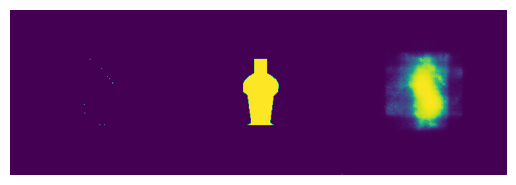

Epoch [1/50], Step [200/3005], Train Loss: 0.0734 , Logging Time Proportion: 0.0053, Data Loading Time Proportion: 0.0018
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

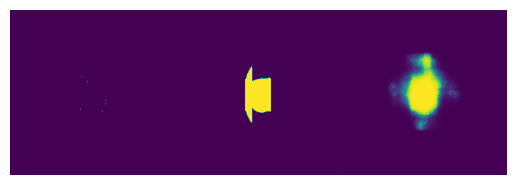

Epoch [1/50], Step [300/3005], Train Loss: 0.0540 , Logging Time Proportion: 0.0132, Data Loading Time Proportion: 0.0020
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

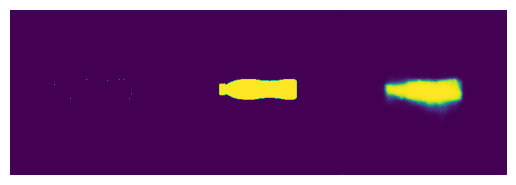

Epoch [1/50], Step [400/3005], Train Loss: 0.0457 , Logging Time Proportion: 0.0059, Data Loading Time Proportion: 0.0021
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

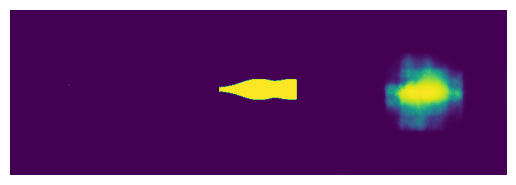

Epoch [1/50], Step [500/3005], Train Loss: 0.0411 , Logging Time Proportion: 0.0066, Data Loading Time Proportion: 0.0021
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

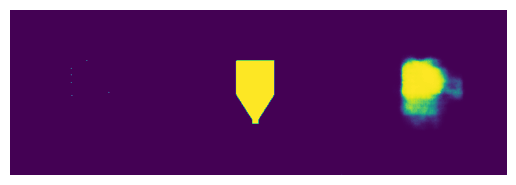

Epoch [1/50], Step [600/3005], Train Loss: 0.0384 , Logging Time Proportion: 0.0060, Data Loading Time Proportion: 0.0021
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

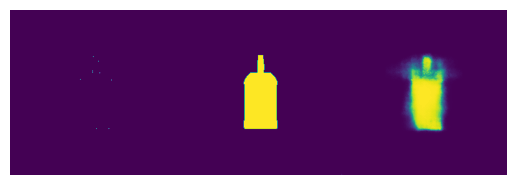

Epoch [1/50], Step [700/3005], Train Loss: 0.0361 , Logging Time Proportion: 0.0061, Data Loading Time Proportion: 0.0020
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

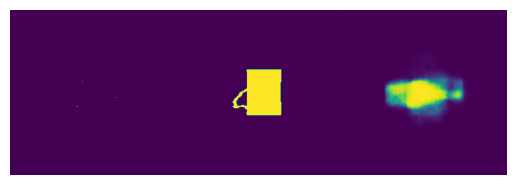

Epoch [1/50], Step [800/3005], Train Loss: 0.0346 , Logging Time Proportion: 0.0070, Data Loading Time Proportion: 0.0021
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

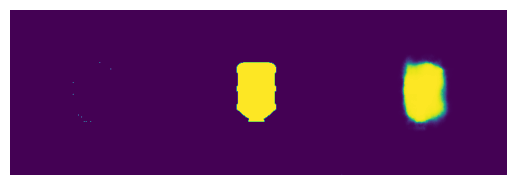

Epoch [1/50], Step [900/3005], Train Loss: 0.0339 , Logging Time Proportion: 0.0062, Data Loading Time Proportion: 0.0020
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

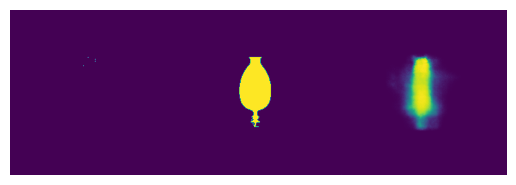

Epoch [1/50], Step [1000/3005], Train Loss: 0.0331 , Logging Time Proportion: 0.0056, Data Loading Time Proportion: 0.0021


/home/daniel/anaconda3/envs/adlr/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


##########################################################################################
Epoch [1/50], Step [1000/3005], Val Loss: 0.0335 Val Log Time Proportion: 0.6246
##########################################################################################
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

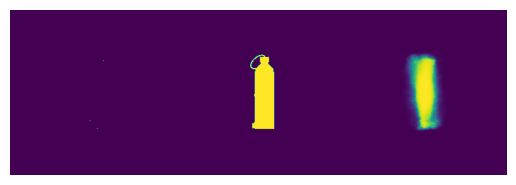

Epoch [1/50], Step [1100/3005], Train Loss: 0.0322 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0003
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

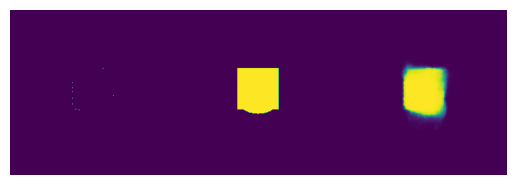

Epoch [1/50], Step [1200/3005], Train Loss: 0.0328 , Logging Time Proportion: 0.0062, Data Loading Time Proportion: 0.0020
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

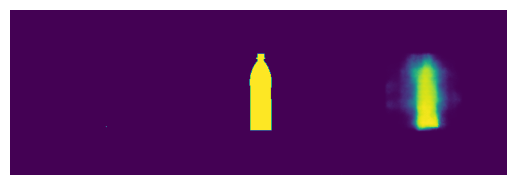

Epoch [1/50], Step [1300/3005], Train Loss: 0.0327 , Logging Time Proportion: 0.0064, Data Loading Time Proportion: 0.0020
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

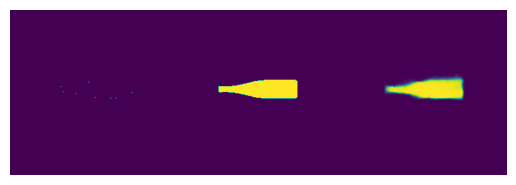

Epoch [1/50], Step [1400/3005], Train Loss: 0.0313 , Logging Time Proportion: 0.0089, Data Loading Time Proportion: 0.0020
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

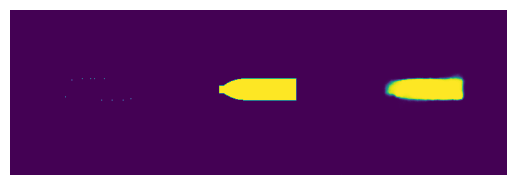

Epoch [1/50], Step [1500/3005], Train Loss: 0.0308 , Logging Time Proportion: 0.0062, Data Loading Time Proportion: 0.0021
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

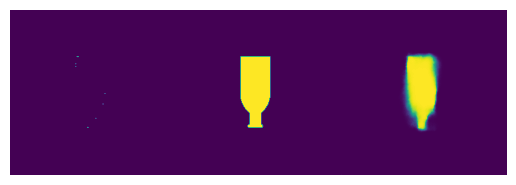

Epoch [1/50], Step [1600/3005], Train Loss: 0.0305 , Logging Time Proportion: 0.0110, Data Loading Time Proportion: 0.0022
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

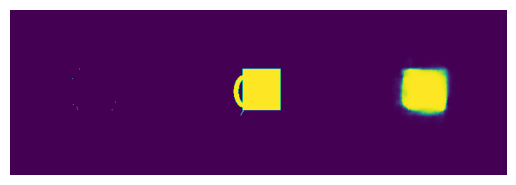

Epoch [1/50], Step [1700/3005], Train Loss: 0.0311 , Logging Time Proportion: 0.0071, Data Loading Time Proportion: 0.0022
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

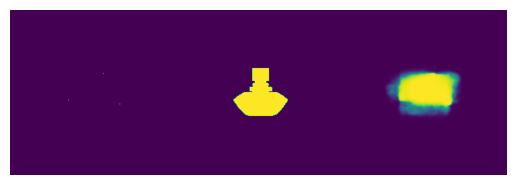

Epoch [1/50], Step [1800/3005], Train Loss: 0.0309 , Logging Time Proportion: 0.0074, Data Loading Time Proportion: 0.0021
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

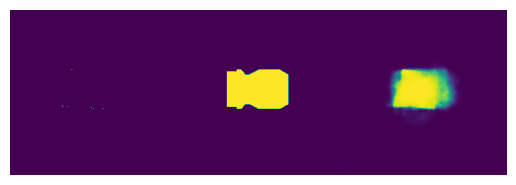

Epoch [1/50], Step [1900/3005], Train Loss: 0.0300 , Logging Time Proportion: 0.0061, Data Loading Time Proportion: 0.0020
Example Rectonsturtion vrom Val Set: 


<Figure size 640x480 with 0 Axes>

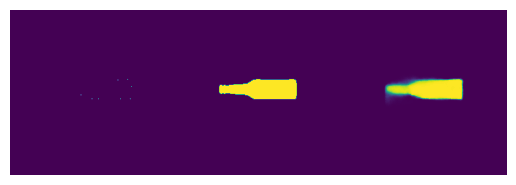

Epoch [1/50], Step [2000/3005], Train Loss: 0.0291 , Logging Time Proportion: 0.0060, Data Loading Time Proportion: 0.0020


KeyboardInterrupt: 

In [14]:


if not fresh_initialized:
    raise ValueError("You are using model that already has been trained")
fresh_initialized = False


# Set up TensorBoard
writer = SummaryWriter(f'runs/U-Net_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')


# Training loop
log_train_period = 100
log_val_period = min(1000, len(train_loader)-1)

# used to meassure proportion of time for calculation for val loss
train_period_stime_val = time.time()
# used to meassure proportion of time for adding images to writer
train_period_stime_train = time.time()

data_loading_time=0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for i, batch in enumerate(train_loader):
        # todo: output should be segmentation map, read an article about it
        
        # measure time to load data 
        st_data_load = time.time()
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)
        data_loading_time += time.time() - st_data_load
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # log data, except validation loss 
        if (i+epoch) % log_train_period == log_train_period-1:  # Log train loss and images every log_train_period batches


            train_duration = time.time() - train_period_stime_train
            
            log_starttime = time.time()
            
        
            # log training loss
            writer.add_scalar('Loss/train', running_train_loss / log_train_period, epoch * len(train_loader) + i)
            

            # Log one reconstructed training image sample
            img_grid = vutils.make_grid([inputs[-1], labels[-1], outputs[-1]])
            writer.add_image('reconstructed_training_images', img_grid, global_step=epoch * len(train_loader) + i)


            # Log one reconstructed validation image sample
            batch = next(iter(train_loader))
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            
            img_grid = vutils.make_grid([inputs[-1], labels[-1], outputs[-1]])
            writer.add_image('reconstructed_validation_images', img_grid, global_step=epoch * len(train_loader) + i)

            # ploting images like this (they are also plotted on tensorboard, but here they are more uebersichtlich somehow)
            print("Example Rectonsturtion vrom Val Set: ")
            plt.figure()
            show_datatripple(inputs[-1].cpu().detach().numpy(), labels[-1].cpu().detach().numpy(), outputs[-1].cpu().detach().numpy())
            plt.show()


            log_duration = time.time() - log_starttime
            log_prop = log_duration / train_duration

            data_loading_prop = data_loading_time /(train_duration - data_loading_time)
            
            data_loading_time = 0
            train_period_stime_train = time.time()
            
            
            print(f'Epoch [{epoch+1 }/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {running_train_loss/log_train_period:.4f}',
                 f', Logging Time Proportion: {log_prop:.4f}, Data Loading Time Proportion: {data_loading_prop:.4f}')
            running_train_loss = 0.0

        
        # calculate and log validation loss  
        if (i+epoch) % log_val_period == log_val_period-1:  # Log val loss every log_val_period batches

            train_duration = time.time() - train_period_stime_val
            
            val_starttime = time.time()
            # calculate validation loss
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch['image'].to(device)
                    labels = batch['label'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
        
            val_loss /= len(val_loader)

            # log validation loss
            writer.add_scalar('Loss/val', val_loss, epoch * len(train_loader) + i)

    
            model.train()
            
            val_duration = time.time() - val_starttime        
            val_t_prop = val_duration / train_duration
    
            
            print('##########################################################################################')        
            print(f'Epoch [{epoch+1 }/{num_epochs}], Step [{i+1}/{len(train_loader)}], Val Loss: {val_loss:.4f}', 
                    f'Val Log Time Proportion: {val_t_prop:.4f}')
            print('##########################################################################################')        

            train_period_stime_val = time.time()
            
            
            
            


# Validation step can be added here similarly and log validation loss

writer.close()